## Importamos librerias

In [441]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import early_stopping
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from datetime import timedelta
from datetime import datetime
from datetime import date
import xgboost as xgb

In [442]:
# Cargar el dataset con la predicción de las entregas
df_results = pl.read_csv("resultados_concatenados.csv") 
df_results = df_results.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"))

max_date = date(2024, 8, 18)
df_results = df_results.filter(pl.col('date') <= max_date)

# Mostrar las primeras filas para verificar la carga
print(df_results)

shape: (1_712, 3)
┌────────────┬───────────┬────────────────────────────┐
│ date       ┆ pred      ┆ calculated_at              │
│ ---        ┆ ---       ┆ ---                        │
│ date       ┆ f64       ┆ str                        │
╞════════════╪═══════════╪════════════════════════════╡
│ 2019-12-12 ┆ 4503.0757 ┆ 2024-08-22 02:05:19.709968 │
│ 2019-12-13 ┆ 3690.1548 ┆ 2024-08-22 02:05:19.709968 │
│ 2019-12-14 ┆ 2657.3467 ┆ 2024-08-22 02:05:19.709968 │
│ 2019-12-15 ┆ 2125.2124 ┆ 2024-08-22 02:05:19.709968 │
│ 2019-12-16 ┆ 4572.128  ┆ 2024-08-22 02:05:19.709968 │
│ …          ┆ …         ┆ …                          │
│ 2024-08-14 ┆ 6057.114  ┆ 2024-08-22 08:11:39.737303 │
│ 2024-08-15 ┆ 5430.66   ┆ 2024-08-22 00:37:05.037591 │
│ 2024-08-16 ┆ 5251.4424 ┆ 2024-08-22 00:37:05.037591 │
│ 2024-08-17 ┆ 1800.5123 ┆ 2024-08-22 00:37:05.037591 │
│ 2024-08-18 ┆ 384.33838 ┆ 2024-08-22 00:37:05.037591 │
└────────────┴───────────┴────────────────────────────┘


In [443]:
### Le agregamos los valores reales
df_true = pl.read_csv("cantidad_entregas_total_20240820.csv") 
df_true = df_true.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"))

min_date = date(2019, 12, 12)
df_true = df_true.filter(pl.col('date') >= min_date)

df = df_true.join(df_results[['date', 'pred']], on="date", how="left")
df = df.rename({"cantidad_entregas": "true"})
print(df)

shape: (1_712, 3)
┌────────────┬──────┬───────────┐
│ date       ┆ true ┆ pred      │
│ ---        ┆ ---  ┆ ---       │
│ date       ┆ i64  ┆ f64       │
╞════════════╪══════╪═══════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  │
│ …          ┆ …    ┆ …         │
│ 2024-08-14 ┆ 5137 ┆ 6057.114  │
│ 2024-08-15 ┆ 5251 ┆ 5430.66   │
│ 2024-08-16 ┆ 5086 ┆ 5251.4424 │
│ 2024-08-17 ┆ 1482 ┆ 1800.5123 │
│ 2024-08-18 ┆ 521  ┆ 384.33838 │
└────────────┴──────┴───────────┘


# Calcular el error Ei = Ri - Pi

In [444]:
df = df.with_columns(
    (pl.col("true") - pl.col("pred")).alias("error")
)
print(df)

shape: (1_712, 4)
┌────────────┬──────┬───────────┬────────────┐
│ date       ┆ true ┆ pred      ┆ error      │
│ ---        ┆ ---  ┆ ---       ┆ ---        │
│ date       ┆ i64  ┆ f64       ┆ f64        │
╞════════════╪══════╪═══════════╪════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 ┆ -1614.2124 │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  ┆ 667.872    │
│ …          ┆ …    ┆ …         ┆ …          │
│ 2024-08-14 ┆ 5137 ┆ 6057.114  ┆ -920.114   │
│ 2024-08-15 ┆ 5251 ┆ 5430.66   ┆ -179.66    │
│ 2024-08-16 ┆ 5086 ┆ 5251.4424 ┆ -165.4424  │
│ 2024-08-17 ┆ 1482 ┆ 1800.5123 ┆ -318.5123  │
│ 2024-08-18 ┆ 521  ┆ 384.33838 ┆ 136.66162  │
└────────────┴──────┴───────────┴────────────┘


# Funciones

In [1]:
def split(X, y, train_end_date):
    X_train = df.filter(pl.col('date') <= train_end_date).select(X).to_numpy()
    X_test = df.filter(pl.col('date') > train_end_date).select(X).to_numpy()

    y_train = df.filter(pl.col('date') <= train_end_date).select(y).to_numpy()
    y_test = df.filter(pl.col('date') > train_end_date).select(y).to_numpy()
    return X_train, X_test, y_train, y_test

In [2]:
def lgbm_model(X_train, X_test, y_train, y_test):
    # Definir el modelo 
    model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', verbose=-1)
    # Espacio de hiperparámetros a explorar
    params = {
        'num_leaves': np.arange(20, 150, 10),  # número de hojas en cada árbol
        'learning_rate': np.linspace(0.01, 0.1, 10),  # tasa de aprendizaje
        'n_estimators': np.arange(100, 1000, 100),  # número de árboles
        'max_depth': np.arange(3, 15, 1),  # profundidad máxima del árbol
        # 'min_child_samples': np.arange(5, 100, 5),  # número mínimo de muestras en un nodo hoja
        # 'subsample': np.linspace(0.5, 1.0, 10),  # fracción de datos utilizada para construir cada árbol
        # 'colsample_bytree': np.linspace(0.5, 1.0, 10)  # fracción de columnas usada para construir cada árbol
        }
    # Configurar TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=10,  # Número de iteraciones de búsqueda
        scoring='neg_root_mean_squared_error',
        cv=tscv,  # Uso de TimeSeriesSplit en lugar de cv estándar
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    print(f"Mejores parámetros encontrados: {best_params}")

    # Hacer predicciones
    y_pred = random_search.predict(X_test)
    
    return y_pred

In [ ]:
def df_con_resultados():
    # Extraer las fechas y feriados para el conjunto de test
    df_grafico = df.filter(pl.col('date') > train_end_date).select(['date', 'tipo_feriado'])

    # Crear un DataFrame con y_test y y_pred junto con las fechas
    df_results = pl.DataFrame({
        'date': dates_test,
        'y_test': y_test.ravel(),
        'y_pred_lgbm': y_pred_lgbm,
        'y_pred_xgb': y_pred_xgb
    })

    # Hacer un join para obtener solo los días de feriado (tipo_feriado == 1 o 2)
    df_feriado_results = df_results.join(
        df_grafico.filter((pl.col('tipo_feriado') == 1) | (pl.col('tipo_feriado') == 2)), 
        on='date', 
        how='inner'
    )

## Evaluación del modelo

In [3]:
def grafico_completo(df, train_end_date, y_test, y_pred):
    # Crear una serie de tiempo para las fechas correspondientes a y_test
    dates_test = df.filter(pl.col('date') > train_end_date).select('date').to_numpy().ravel()

    # Graficar la serie temporal
    plt.figure(figsize=(14, 7))
    plt.plot(dates_test, y_test, label='Errores Reales', color='blue')
    plt.plot(dates_test, y_pred, label='Errores Predichos', color='red')

    plt.xlabel('Fecha')
    plt.ylabel('Error')
    plt.title('Comparación de la serie temporal de Valores Reales vs Predicciones')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

### Vemos si mejoró lo que teníamos

In [ ]:
def df_comparation(df, train_end_date):
    df_test = df.filter(pl.col('date') > train_end_date)
    ## Tomamos lgb, pero se puede cambiar por xgb
    df_comparation = df_test.join(df_feriado_results[['date', 'y_pred_lgbm']], on='date', how='left')
    df_comparation = df_comparation.with_columns(
        (pl.col("pred") + pl.col("y_pred_lgbm")).alias("pred_semi_corregido")
    )
    df_comparation = df_comparation.with_columns(
                    pl.when(pl.col('pred_semi_corregido').is_null()).then(pl.col('pred')).otherwise(pl.col('pred_semi_corregido')).alias('pred_corregido')
                )
    df_comparation = df_comparation.with_columns(
        (pl.col("true") - pl.col("pred_corregido")).alias("error_corregido")
    )
    print(df_comparation)

# Feriados

### Tipo de feriado

In [445]:
# Cargar el dataset con los tipos de feriados
df_feriado = pl.read_csv("tipo_feriados.csv")
df_feriado = df_feriado.with_columns(pl.col('date').str.strptime(pl.Date, '%Y-%m-%d'))
print(df_feriado)

shape: (1_825, 6)
┌────────────┬───────────────────┬────────────┬────────────────┬─────────┬──────────────┐
│ date       ┆ cantidad_entregas ┆ is_holiday ┆ holiday_name   ┆ weekday ┆ tipo_feriado │
│ ---        ┆ ---               ┆ ---        ┆ ---            ┆ ---     ┆ ---          │
│ date       ┆ i64               ┆ bool       ┆ str            ┆ i64     ┆ i64          │
╞════════════╪═══════════════════╪════════════╪════════════════╪═════════╪══════════════╡
│ 2019-09-05 ┆ 2769              ┆ false      ┆ null           ┆ 4       ┆ 0            │
│ 2019-09-06 ┆ 8474              ┆ false      ┆ null           ┆ 5       ┆ 0            │
│ 2019-09-07 ┆ 613               ┆ false      ┆ null           ┆ 6       ┆ -1           │
│ 2019-09-08 ┆ 346               ┆ false      ┆ null           ┆ 7       ┆ -1           │
│ 2019-09-09 ┆ 4814              ┆ false      ┆ null           ┆ 1       ┆ 0            │
│ …          ┆ …                 ┆ …          ┆ …              ┆ …       ┆ …      

In [446]:
len(df_feriado['date'].unique())

1813

Notamos que hay 12 fechas repetidas, es decir que 12 veces pasa que hay mas de un feriado. Veamos qué fechas son

In [447]:
# Agrupar por la columna 'date' y contar las ocurrencias de cada fecha
df_repeated_dates = df_feriado.group_by("date").agg(
    pl.count("date").alias("count")
)
# Filtrar para obtener solo las fechas que aparecen más de una vez
df_repeated_dates = df_repeated_dates.filter(pl.col("count") > 1)
# Mostrar las fechas repetidas
print(df_repeated_dates)

shape: (11, 2)
┌────────────┬───────┐
│ date       ┆ count │
│ ---        ┆ ---   │
│ date       ┆ u32   │
╞════════════╪═══════╡
│ 2020-04-09 ┆ 2     │
│ 2022-04-15 ┆ 2     │
│ 2023-04-07 ┆ 2     │
│ 2020-04-10 ┆ 2     │
│ 2021-04-02 ┆ 3     │
│ …          ┆ …     │
│ 2024-04-24 ┆ 2     │
│ 2022-07-09 ┆ 2     │
│ 2022-04-17 ┆ 2     │
│ 2021-04-04 ┆ 2     │
│ 2024-06-17 ┆ 2     │
└────────────┴───────┘


In [448]:
# Hacer un join con el DataFrame original para obtener las filas con fechas repetidas
df_repeated_holidays = df_feriado.join(df_repeated_dates.select("date"), on="date", how="inner")

# Mostrar las filas del df_feriado que tienen fechas repetidas
print(df_repeated_holidays)

shape: (23, 6)
┌────────────┬───────────────────┬────────────┬───────────────────────────┬─────────┬──────────────┐
│ date       ┆ cantidad_entregas ┆ is_holiday ┆ holiday_name              ┆ weekday ┆ tipo_feriado │
│ ---        ┆ ---               ┆ ---        ┆ ---                       ┆ ---     ┆ ---          │
│ date       ┆ i64               ┆ bool       ┆ str                       ┆ i64     ┆ i64          │
╞════════════╪═══════════════════╪════════════╪═══════════════════════════╪═════════╪══════════════╡
│ 2020-04-09 ┆ 2876              ┆ true       ┆ Maundy Thursday           ┆ 4       ┆ 2            │
│ 2020-04-09 ┆ 2876              ┆ true       ┆ First day of Passover     ┆ 4       ┆ 2            │
│ 2020-04-10 ┆ 1321              ┆ true       ┆ Good Friday               ┆ 5       ┆ 2            │
│ 2020-04-10 ┆ 1321              ┆ true       ┆ Second Day of Passover    ┆ 5       ┆ 2            │
│ 2021-04-02 ┆ 889               ┆ true       ┆ Good Friday               ┆ 

Tomamos la siguiente decision para tratar a los repetidos: cuando tenemos en una misma fecha el feriado de tipo 1 y tipo 2, priorizamos el tipo 1 ya que es un feriado "más importante", luego, si hay tipo de feriados 2, nos vamos a quedar con el promedio de variacion de ambos feriados. El caso donde en una misma fecha tenemos mas de un feriado de tipo 1 no lo tenemos, asi que este caso lo descartamos (no suele pasar en general para los feriados que tomamos)

Esto lo hacemos una vez que agregamos la variacion al df

In [449]:
df_feriado = df_feriado.select(['date', 'holiday_name', 'tipo_feriado'])
df = df.join(df_feriado, on='date', how='left')
print(df)

shape: (1_724, 6)
┌────────────┬──────┬───────────┬────────────┬────────────────┬──────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_name   ┆ tipo_feriado │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ ---            ┆ ---          │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ str            ┆ i64          │
╞════════════╪══════╪═══════════╪════════════╪════════════════╪══════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ null           ┆ 0            │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ null           ┆ 0            │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ null           ┆ -1           │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 ┆ -1614.2124 ┆ null           ┆ -1           │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  ┆ 667.872    ┆ null           ┆ 0            │
│ …          ┆ …    ┆ …         ┆ …          ┆ …              ┆ …            │
│ 2024-08-14 ┆ 5137 ┆ 6057.114  ┆ -920.114   ┆ null           ┆ 0            │
│ 2024-08-15 ┆ 5251 ┆ 5430.66   ┆ 

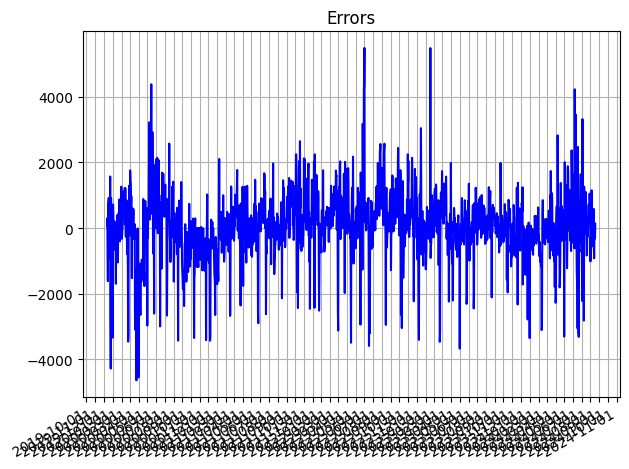

In [450]:
#  Graficar 'error' en el primer subgráfico
plt.plot(df['date'], df['error'], color='blue')
plt.title('Errors')
plt.grid(True)

# Mejorar el formato de la fecha en el eje x
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gcf().autofmt_xdate()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

### Variación del feriado

In [451]:
# Cargar el dataset con la variacion de cada feriado
df_variacion = pl.read_parquet("variacion_tipo_feriados.parquet")
print(df_variacion)

shape: (44, 5)
┌───────────────┬───────────────────────────┬──────────────┬──────────────────┬────────────────────┐
│ grupo_feriado ┆ holiday_name              ┆ tipo_feriado ┆ dates            ┆ promedio_variacion │
│ ---           ┆ ---                       ┆ ---          ┆ ---              ┆ ---                │
│ i64           ┆ str                       ┆ i64          ┆ list[list[date]] ┆ f64                │
╞═══════════════╪═══════════════════════════╪══════════════╪══════════════════╪════════════════════╡
│ 1             ┆ Public Sector Half Day    ┆ 2            ┆ [[2022-01-13],   ┆ 14.346576          │
│               ┆                           ┆              ┆ [2022-01-14]]    ┆                    │
│ 2             ┆ End of Ramadan            ┆ 2            ┆ [[2020-05-24],   ┆ -6.851118          │
│               ┆                           ┆              ┆ [2021-05-13], …… ┆                    │
│ 3             ┆ Ramadan Start             ┆ 2            ┆ [[2023-03-23], 

In [452]:
# Asignar 1 como valor por defecto para la columna `promedio_variacion`
df = df.with_columns(pl.lit(1).alias('promedio_variacion'))

# Iterar sobre cada fila en el DataFrame con las variaciones
for row in df_variacion.iter_rows(named=True):
    variacion = row['promedio_variacion']
    fechas = row['dates']  # Es una lista de listas de fechas

    # Iterar sobre las listas de fechas dentro de 'dates'
    for lista_fechas in fechas:
        for fecha in lista_fechas:
            # Asignar la variación a la fecha correspondiente en df_original
            df = df.with_columns(
                pl.when(pl.col('date') == fecha).then(variacion).otherwise(pl.col('promedio_variacion')).alias('promedio_variacion')
            )

# Revisa el DataFrame final
print(df)


shape: (1_724, 7)
┌────────────┬──────┬───────────┬────────────┬────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_name   ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ ---            ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ str            ┆ i64          ┆ f64                │
╞════════════╪══════╪═══════════╪════════════╪════════════════╪══════════════╪════════════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 ┆ -1614.2124 ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  ┆ 667.872    ┆ null           ┆ 0            ┆ 1.0

#### Tratamos los repetidos

In [453]:
# Filtrar para mantener solo las filas con tipo de feriado 1 si existe al menos uno
df_tipo1 = df.filter(pl.col('tipo_feriado') == 1)
#print(df_tipo1.filter(pl.col('date') == date(2024,6,17)))

# Crear una columna que indique si hay al menos un tipo de feriado 1 para cada fecha
df_min = df.with_columns(
    pl.col('tipo_feriado').min().over('date').alias('tipo_feriado_min')
)
#print(df_min.filter(pl.col('date') == date(2024,6,17)))

# Si no hay tipo de feriado 1, tomar el promedio y concatenar nombres de las filas con tipo de feriado 2
df_tipo2 = df_min.filter(pl.col('tipo_feriado_min') == 2).group_by('date').agg(
    [
        pl.first('true').alias('true'),
        pl.first('pred').alias('pred'),
        pl.first('error').alias('error'),
        #pl.first('holiday_name').alias('holiday_name'),
        pl.col('holiday_name').unique().cast(str).str.join(' / ').alias('holiday_name'),  # Concatenar strings con '/'
        pl.first('tipo_feriado').alias('tipo_feriado'),
        pl.mean('promedio_variacion').alias('promedio_variacion')
    ]
)
#print(df_tipo2.filter(pl.col('date') == date(2020,4,9)))
df_final = pl.concat([df_tipo1, df_tipo2])
print(df_final)

shape: (178, 7)
┌────────────┬──────┬───────────┬────────────┬───────────────────┬──────────────┬──────────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_name      ┆ tipo_feriado ┆ promedio_variaci │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ ---               ┆ ---          ┆ on               │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ str               ┆ i64          ┆ ---              │
│            ┆      ┆           ┆            ┆                   ┆              ┆ f64              │
╞════════════╪══════╪═══════════╪════════════╪═══════════════════╪══════════════╪══════════════════╡
│ 2019-12-25 ┆ 231  ┆ 4509.064  ┆ -4278.064  ┆ Christmas Day     ┆ 1            ┆ 75.138578        │
│ 2019-12-31 ┆ 1460 ┆ 3858.5183 ┆ -2398.5183 ┆ New Year's Eve    ┆ 1            ┆ 54.880224        │
│ 2020-01-01 ┆ 232  ┆ 3568.2732 ┆ -3336.2732 ┆ New Year's Day    ┆ 1            ┆ 74.926052        │
│ 2020-02-24 ┆ 1180 ┆ 4639.808  ┆ -3459.808  ┆ Carnival / Shrove ┆ 1       

In [454]:
# Filtrar filas que están en el primer DataFrame pero no en el segundo
df_faltantes = df.join(df_final, on='date', how='anti')
df_concatenado = pl.concat([df_final, df_faltantes])
df = df_concatenado.sort('date')
print(df)
print(len(df) == len(df['date'].unique())) #ya no tenemos repetidos

shape: (1_712, 7)
┌────────────┬──────┬───────────┬────────────┬────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_name   ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ ---            ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ str            ┆ i64          ┆ f64                │
╞════════════╪══════╪═══════════╪════════════╪════════════════╪══════════════╪════════════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 ┆ -1614.2124 ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  ┆ 667.872    ┆ null           ┆ 0            ┆ 1.0

## Predicción de errores

In [455]:
# Separar el último año para test
train_end_date = date(2023,7,31) #se entrena con 2 años y testea con el 5% o un mes pero aca vemos solo feriados así que está bien
# Separar el conjunto de entrenamiento y prueba basándote en la fecha
X_train = df.filter(pl.col('date') <= train_end_date).select(['pred', 'tipo_feriado', 'promedio_variacion']).to_numpy()
X_test = df.filter(pl.col('date') > train_end_date).select(['pred', 'tipo_feriado', 'promedio_variacion']).to_numpy()

y_train = df.filter(pl.col('date') <= train_end_date).select('error').to_numpy()
y_test = df.filter(pl.col('date') > train_end_date).select('error').to_numpy()
print(len(y_test))

384


In [456]:
# Configurar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

El uso de TimeSeriesSplit asegura que el modelo se entrene y valide de una manera que respete la naturaleza temporal de los datos. Esto evita problemas de fuga de datos (leakage), donde el modelo podría aprender del futuro durante el entrenamiento, lo cual no sería realista al aplicarlo en producción.

### LightGBM

Basado en el algoritmo de boosting de árboles de decisión.

Primero dividimos los datos. Como estamos trabajando en una serie temporal, no podemos trabajar tomando los datos de forma random

Entrenamiento del modelo

Definimos params de busqueda

In [457]:
# Definir el modelo y los parámetros de búsqueda
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', verbose=-1)

In [458]:
# Espacio de hiperparámetros a explorar
param_dist_lgbm = {
    'num_leaves': np.arange(20, 150, 10),  # número de hojas en cada árbol
    'learning_rate': np.linspace(0.01, 0.1, 10),  # tasa de aprendizaje
    'n_estimators': np.arange(100, 1000, 100),  # número de árboles
    'max_depth': np.arange(3, 15, 1),  # profundidad máxima del árbol
   # 'min_child_samples': np.arange(5, 100, 5),  # número mínimo de muestras en un nodo hoja
   # 'subsample': np.linspace(0.5, 1.0, 10),  # fracción de datos utilizada para construir cada árbol
   # 'colsample_bytree': np.linspace(0.5, 1.0, 10)  # fracción de columnas usada para construir cada árbol
}

In [459]:
random_search_lgbm = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgbm,
    n_iter=10,  # Número de iteraciones de búsqueda
    scoring='neg_root_mean_squared_error',
    cv=tscv,  # Uso de TimeSeriesSplit en lugar de cv estándar
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [460]:
random_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(objective='regression', verbose=-1),
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [516]:
# Obtener los mejores parámetros
best_params_lgbm = random_search_lgbm.best_params_
print(f"Mejores parámetros encontrados: {best_params_lgbm}")

Mejores parámetros encontrados: {'num_leaves': 30, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05000000000000001}


In [517]:
# Hacer predicciones
y_pred_lgbm = random_search_lgbm.predict(X_test)

ValueError: Number of features of the model must match the input. Model n_features_ is 3 and input n_features is 4

#### Evaluación del modelo

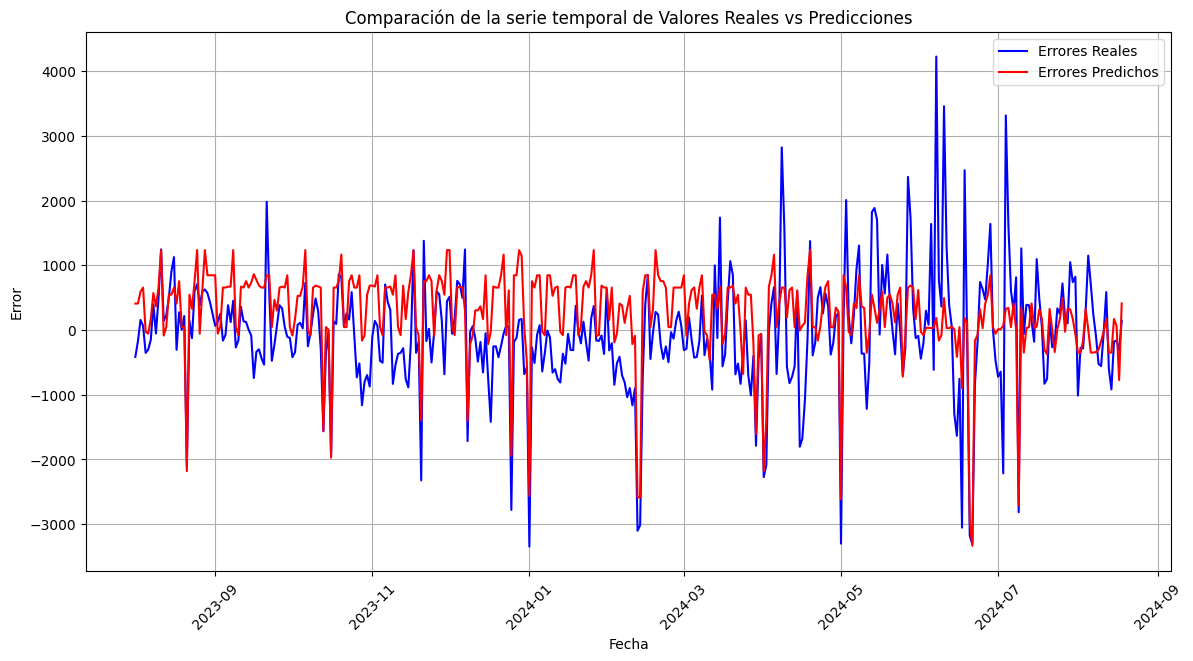

In [518]:
# Crear una serie de tiempo para las fechas correspondientes a y_test
dates_test = df.filter(pl.col('date') > train_end_date).select('date').to_numpy().ravel()

# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(dates_test, y_test, label='Errores Reales', color='blue')
plt.plot(dates_test, y_pred_lgbm, label='Errores Predichos', color='red')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Valores Reales vs Predicciones')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

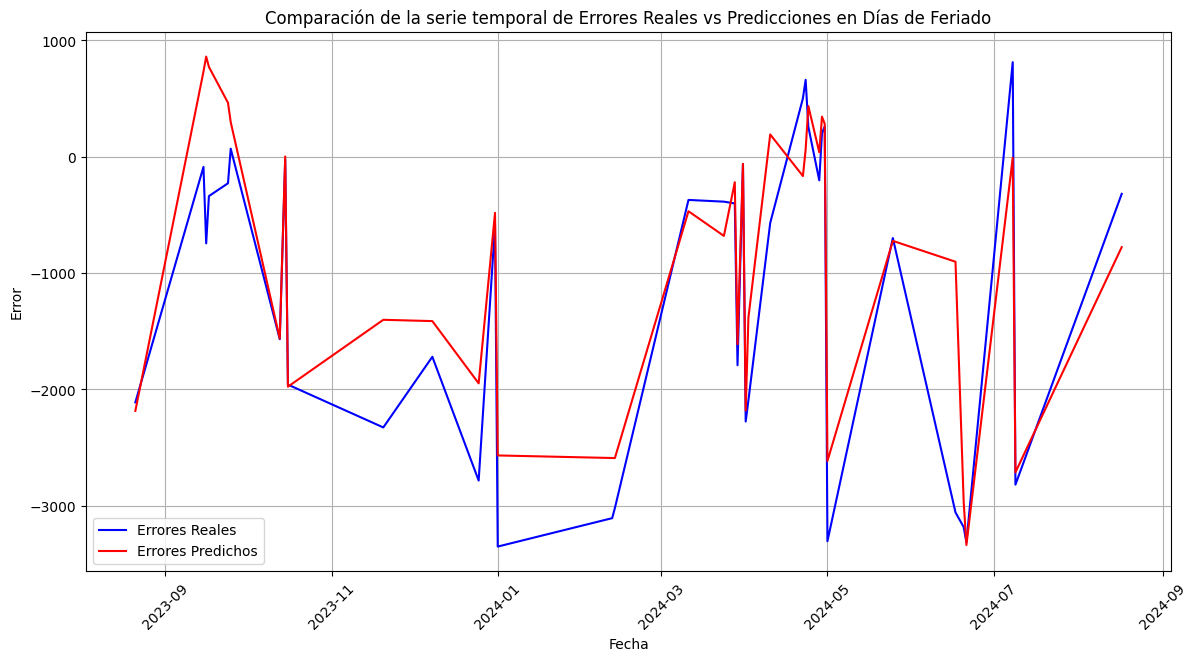

In [519]:
# Extraer las fechas y feriados para el conjunto de test
df_grafico = df.filter(pl.col('date') > train_end_date).select(['date', 'tipo_feriado'])

# Crear un DataFrame con y_test y y_pred junto con las fechas
df_results = pl.DataFrame({
    'date': dates_test,
    'y_test': y_test.ravel(),
    'y_pred_lgbm': y_pred_lgbm
})

# Hacer un join para obtener solo los días de feriado (tipo_feriado == 1 o 2)
df_feriado_results = df_results.join(
    df_grafico.filter((pl.col('tipo_feriado') == 1) | (pl.col('tipo_feriado') == 2)), 
    on='date', 
    how='inner'
)

# Graficar la serie temporal solo para los días de feriado
plt.figure(figsize=(14, 7))
plt.plot(df_feriado_results['date'], df_feriado_results['y_test'], label='Errores Reales', color='blue')
plt.plot(df_feriado_results['date'], df_feriado_results['y_pred_lgbm'], label='Errores Predichos', color='red')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Errores Reales vs Predicciones en Días de Feriado')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

##### MAPE

In [520]:
def calculate_mape(y_true, y_pred):
    # Evitar divisiones por cero
    #nonzero_indices = y_true != 0
    #y_true_nonzero = y_true[nonzero_indices]
    #y_pred_nonzero = y_pred[nonzero_indices]
    
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [521]:
mape = calculate_mape(df_feriado_results['y_test'].to_numpy(), df_feriado_results['y_pred_lgbm'].to_numpy())
print(f"MAPE: {mape:.2f}%")

MAPE: 93.84%


### XGBoost

También es un modelo basado en árboles de decisión, pero con algunas diferencias en la forma en que optimiza los árboles y la regularización.

In [522]:
# Parámetros a explorar
param_dist_xgb = {
    'n_estimators': np.arange(100, 1000, 100),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 15, 1),
    'min_child_weight': np.arange(1, 10, 1),
    'gamma': np.linspace(0, 0.5, 10),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'reg_alpha': np.logspace(-4, 1, 10),  # regularización L1
    'reg_lambda': np.logspace(-4, 1, 10)  # regularización L2
}

# Inicializar el modelo
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Configurar la búsqueda aleatoria
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_dist_xgb, 
                                   n_iter=100, cv=tscv, verbose=1, n_jobs=-1, 
                                   scoring='neg_mean_squared_error', random_state=42)

In [523]:
# Ajustar el modelo a los datos
random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=No...
       2.78255940e+00, 1.00000000e+01]),
                                        'reg_lambda': array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01]),
                                        'subsample': array([0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [524]:
# Obtener los mejores parámetros
best_params = random_search_xgb.best_params_
print(f"Mejores parámetros encontrados: {best_params}")

Mejores parámetros encontrados: {'subsample': 0.6111111111111112, 'reg_lambda': 0.7742636826811278, 'reg_alpha': 0.004641588833612782, 'n_estimators': 100, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.05555555555555555, 'colsample_bytree': 0.9444444444444444}


In [525]:
# Hacer predicciones
y_pred_xgb = random_search_xgb.predict(X_test)

#### Evaluación del modelo

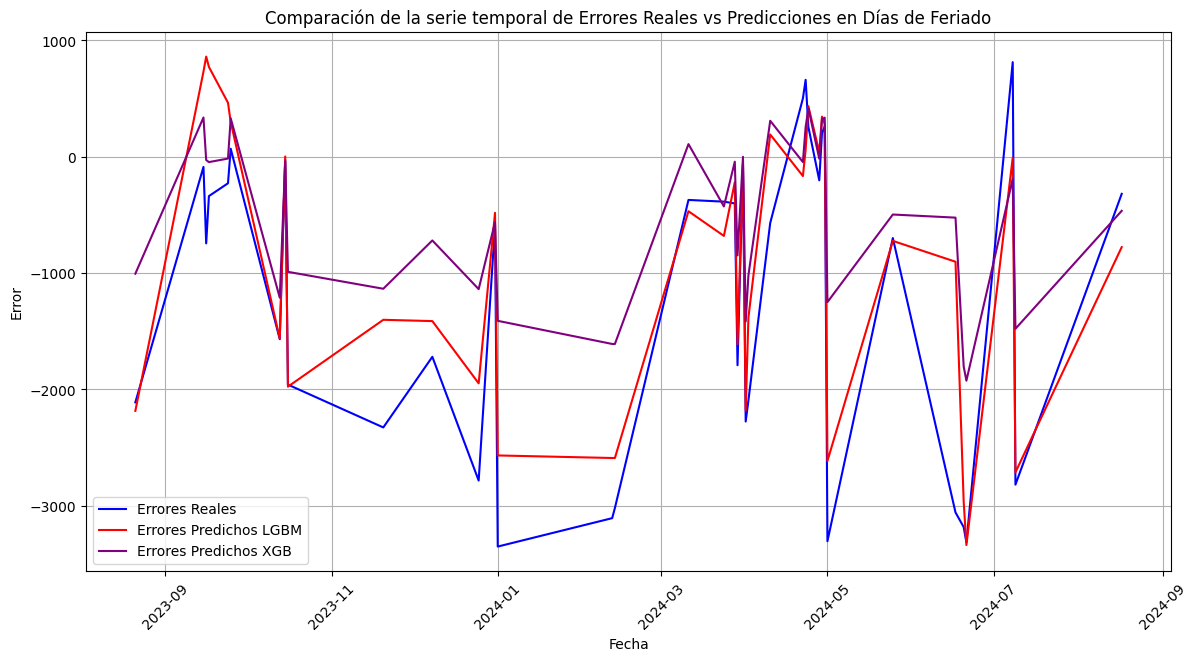

In [526]:
# Extraer las fechas y feriados para el conjunto de test
df_grafico = df.filter(pl.col('date') > train_end_date).select(['date', 'tipo_feriado'])

# Crear un DataFrame con y_test y y_pred junto con las fechas
df_results = pl.DataFrame({
    'date': dates_test,
    'y_test': y_test.ravel(),
    'y_pred_lgbm': y_pred_lgbm,
    'y_pred_xgb': y_pred_xgb
})

# Hacer un join para obtener solo los días de feriado (tipo_feriado == 1 o 2)
df_feriado_results = df_results.join(
    df_grafico.filter((pl.col('tipo_feriado') == 1) | (pl.col('tipo_feriado') == 2)), 
    on='date', 
    how='inner'
)

# Graficar la serie temporal solo para los días de feriado
plt.figure(figsize=(14, 7))
plt.plot(df_feriado_results['date'], df_feriado_results['y_test'], label='Errores Reales', color='blue')
plt.plot(df_feriado_results['date'], df_feriado_results['y_pred_lgbm'], label='Errores Predichos LGBM', color='red')
plt.plot(df_feriado_results['date'], df_feriado_results['y_pred_xgb'], label='Errores Predichos XGB', color='purple')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Errores Reales vs Predicciones en Días de Feriado')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [527]:
# Crear un índice para cada fecha
df_feriado_results = df_feriado_results.with_columns([
    pl.arange(0, df_feriado_results.height).alias('index')
])

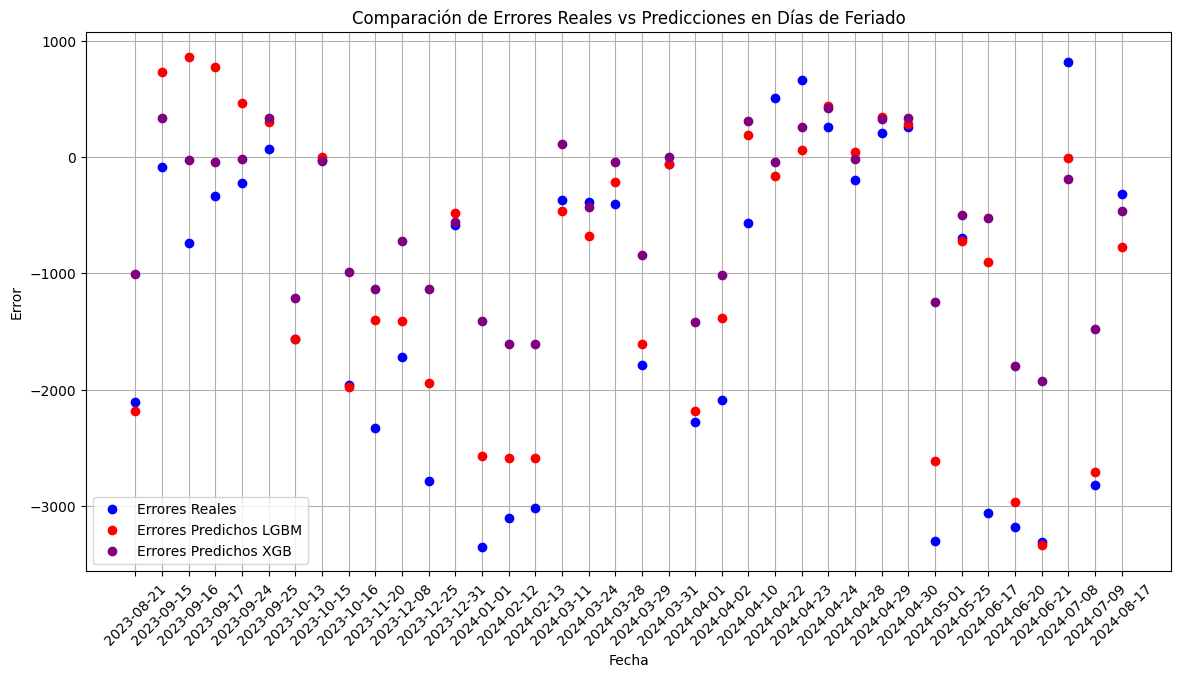

In [528]:
#### Ver si hago función o queda así
plt.figure(figsize=(14, 7))

# Graficar los valores de y_test y las predicciones usando el índice en el eje X
plt.plot(df_feriado_results['index'], df_feriado_results['y_test'], label='Errores Reales', color='blue', marker='o', linestyle='None')
plt.plot(df_feriado_results['index'], df_feriado_results['y_pred_lgbm'], label='Errores Predichos LGBM', color='red', marker='o', linestyle='None')
plt.plot(df_feriado_results['index'], df_feriado_results['y_pred_xgb'], label='Errores Predichos XGB', color='purple', marker='o', linestyle='None')

# Reemplazar las etiquetas del eje X por las fechas correspondientes
plt.xticks(df_feriado_results['index'], df_feriado_results['date'], rotation=45)

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de Errores Reales vs Predicciones en Días de Feriado')
plt.legend()
plt.grid(True)
plt.show()


In [529]:
mape = calculate_mape(df_feriado_results['y_test'].to_numpy(), df_feriado_results['y_pred_xgb'].to_numpy())
print(f"MAPE: {mape:.2f}%")

MAPE: 83.14%


XGBoost da mejor métrica pero LGBM se ve mejor en el gráfico, le pifea por menos

#### Comparamos para ver performance

In [530]:
print(df_feriado_results)

shape: (38, 6)
┌────────────┬────────────┬──────────────┬──────────────┬──────────────┬───────┐
│ date       ┆ y_test     ┆ y_pred_lgbm  ┆ y_pred_xgb   ┆ tipo_feriado ┆ index │
│ ---        ┆ ---        ┆ ---          ┆ ---          ┆ ---          ┆ ---   │
│ date       ┆ f64        ┆ f64          ┆ f32          ┆ i64          ┆ i64   │
╞════════════╪════════════╪══════════════╪══════════════╪══════════════╪═══════╡
│ 2023-08-21 ┆ -2110.4958 ┆ -2183.712918 ┆ -1004.795715 ┆ 2            ┆ 0     │
│ 2023-09-15 ┆ -87.1475   ┆ 731.603327   ┆ 337.729034   ┆ 2            ┆ 1     │
│ 2023-09-16 ┆ -744.2811  ┆ 861.292676   ┆ -28.173325   ┆ 2            ┆ 2     │
│ 2023-09-17 ┆ -337.7173  ┆ 772.361455   ┆ -45.595299   ┆ 2            ┆ 3     │
│ 2023-09-24 ┆ -227.7388  ┆ 464.322726   ┆ -15.30054    ┆ 2            ┆ 4     │
│ …          ┆ …          ┆ …            ┆ …            ┆ …            ┆ …     │
│ 2024-06-20 ┆ -3182.38   ┆ -2963.454034 ┆ -1801.183838 ┆ 1            ┆ 33    │
│ 2024-06-21 

In [531]:
df_test = df.filter(pl.col('date') > train_end_date)
## Tomamos lgb, pero se puede cambiar por xgb
df_comparation = df_test.join(df_feriado_results[['date', 'y_pred_lgbm']], on='date', how='left')
df_comparation = df_comparation.with_columns(
    (pl.col("pred") + pl.col("y_pred_lgbm")).alias("pred_semi_corregido")
)
df_comparation = df_comparation.with_columns(
                pl.when(pl.col('pred_semi_corregido').is_null()).then(pl.col('pred')).otherwise(pl.col('pred_semi_corregido')).alias('pred_corregido')
            )
df_comparation = df_comparation.with_columns(
    (pl.col("true") - pl.col("pred_corregido")).alias("error_corregido")
)
print(df_comparation)

shape: (384, 11)
┌────────────┬──────┬───────────┬───────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ date       ┆ true ┆ pred      ┆ error     ┆ … ┆ y_pred_lgb ┆ pred_semi_ ┆ pred_corre ┆ error_cor │
│ ---        ┆ ---  ┆ ---       ┆ ---       ┆   ┆ m          ┆ corregido  ┆ gido       ┆ regido    │
│ date       ┆ i64  ┆ f64       ┆ f64       ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│            ┆      ┆           ┆           ┆   ┆ f64        ┆ f64        ┆ f64        ┆ f64       │
╞════════════╪══════╪═══════════╪═══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 2023-08-01 ┆ 3886 ┆ 4303.8433 ┆ -417.8433 ┆ … ┆ null       ┆ null       ┆ 4303.8433  ┆ -417.8433 │
│ 2023-08-02 ┆ 4113 ┆ 4288.6836 ┆ -175.6836 ┆ … ┆ null       ┆ null       ┆ 4288.6836  ┆ -175.6836 │
│ 2023-08-03 ┆ 4129 ┆ 3974.3462 ┆ 154.6538  ┆ … ┆ null       ┆ null       ┆ 3974.3462  ┆ 154.6538  │
│ 2023-08-04 ┆ 3644 ┆ 3580.3474 ┆ 63.6526   ┆ … ┆ null       ┆ null       

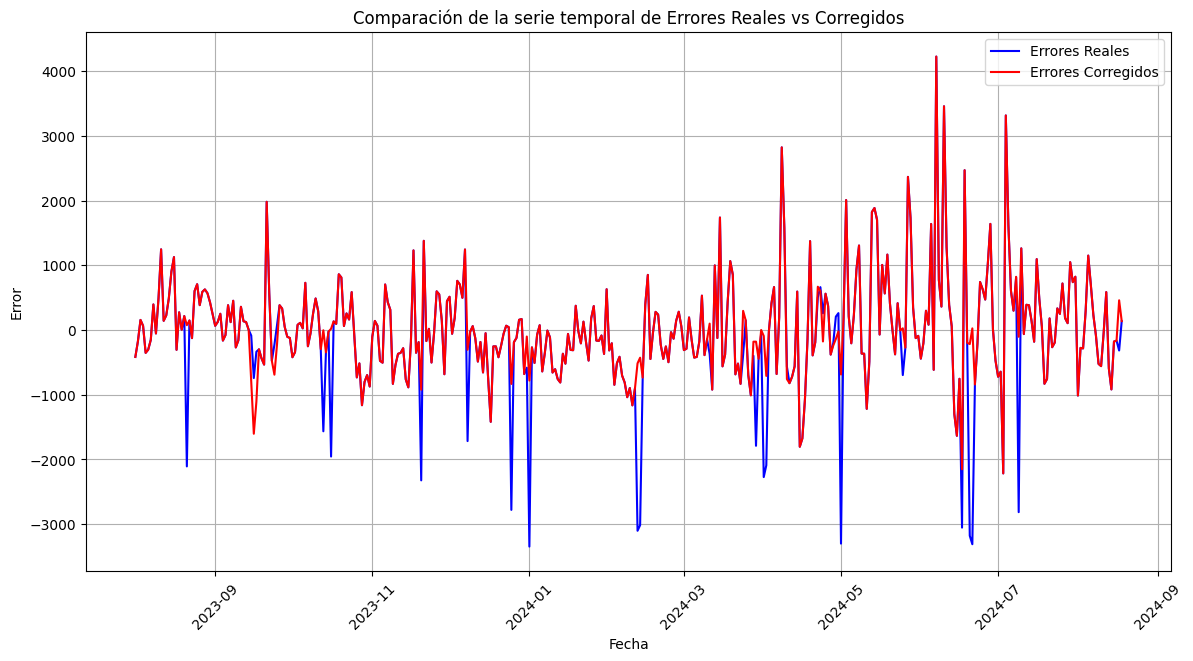

In [532]:
# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(df_comparation['date'], df_comparation['error'], label='Errores Reales', color='blue')
plt.plot(df_comparation['date'], df_comparation['error_corregido'], label='Errores Corregidos', color='red')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Errores Reales vs Corregidos')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [533]:
print(df_comparation['error'].describe())

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 384.0      │
│ null_count ┆ 0.0        │
│ mean       ┆ -59.734147 │
│ std        ┆ 920.023904 │
│ min        ┆ -3350.0415 │
│ 25%        ┆ -440.2402  │
│ 50%        ┆ -71.31     │
│ 75%        ┆ 368.273    │
│ max        ┆ 4226.332   │
└────────────┴────────────┘


In [534]:
print(df_comparation['error_corregido'].describe())

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 384.0      │
│ null_count ┆ 0.0        │
│ mean       ┆ 31.479029  │
│ std        ┆ 754.863879 │
│ min        ┆ -2218.672  │
│ 25%        ┆ -389.5314  │
│ 50%        ┆ -56.96265  │
│ 75%        ┆ 370.1028   │
│ max        ┆ 4226.332   │
└────────────┴────────────┘


##### Agregamos fin de semana

In [535]:
df_results

date,y_test,y_pred_lgbm,y_pred_xgb
date,f64,f64,f32
2023-08-01,-417.8433,407.620454,324.290161
2023-08-02,-175.6836,407.620454,324.290161
2023-08-03,154.6538,590.855869,379.620544
2023-08-04,63.6526,654.640729,467.933838
2023-08-05,-355.2804,-28.616077,-17.453152
…,…,…,…
2024-08-14,-920.114,-350.736894,-124.884636
2024-08-15,-179.66,168.93651,97.17804
2024-08-16,-165.4424,64.11504,165.74263


In [536]:
df_finde_results = df_results.join(
    df_grafico.filter(pl.col('tipo_feriado') != 0), 
    on='date', 
    how='inner'
)
print(df_finde_results)

shape: (138, 5)
┌────────────┬───────────┬─────────────┬─────────────┬──────────────┐
│ date       ┆ y_test    ┆ y_pred_lgbm ┆ y_pred_xgb  ┆ tipo_feriado │
│ ---        ┆ ---       ┆ ---         ┆ ---         ┆ ---          │
│ date       ┆ f64       ┆ f64         ┆ f32         ┆ i64          │
╞════════════╪═══════════╪═════════════╪═════════════╪══════════════╡
│ 2023-08-05 ┆ -355.2804 ┆ -28.616077  ┆ -17.453152  ┆ -1           │
│ 2023-08-06 ┆ -304.7046 ┆ -57.959037  ┆ 3.857746    ┆ -1           │
│ 2023-08-12 ┆ 140.4397  ┆ -86.683514  ┆ -32.088444  ┆ -1           │
│ 2023-08-13 ┆ 224.5967  ┆ 42.96643    ┆ 95.820457   ┆ -1           │
│ 2023-08-19 ┆ 3.7073    ┆ 43.343823   ┆ 129.362762  ┆ -1           │
│ …          ┆ …         ┆ …           ┆ …           ┆ …            │
│ 2024-08-04 ┆ 294.13867 ┆ 324.208221  ┆ 206.926056  ┆ -1           │
│ 2024-08-10 ┆ -559.8755 ┆ -172.822483 ┆ -56.521084  ┆ -1           │
│ 2024-08-11 ┆ -39.1438  ┆ -25.597852  ┆ -9.171628   ┆ -1           │
│ 20

In [537]:
df_finde_results = df_finde_results.rename({"y_pred_lgbm": "y_pred_lgbm_finde"})
df_comparation = df_comparation.join(df_finde_results[['date', 'y_pred_lgbm_finde']], on='date', how='left')
df_comparation = df_comparation.with_columns(
    (pl.col("pred") + pl.col("y_pred_lgbm_finde")).alias("pred_finde_semi_corregido")
)
df_comparation = df_comparation.with_columns(
                pl.when(pl.col('pred_finde_semi_corregido').is_null()).then(pl.col('pred')).otherwise(pl.col('pred_finde_semi_corregido')).alias('pred_finde_corregido')
            )
df_comparation = df_comparation.with_columns(
    (pl.col("true") - pl.col("pred_finde_corregido")).alias("error_finde_corregido")
)
print(df_comparation)

shape: (384, 15)
┌────────────┬──────┬───────────┬───────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ date       ┆ true ┆ pred      ┆ error     ┆ … ┆ y_pred_lgb ┆ pred_finde ┆ pred_finde ┆ error_fin │
│ ---        ┆ ---  ┆ ---       ┆ ---       ┆   ┆ m_finde    ┆ _semi_corr ┆ _corregido ┆ de_correg │
│ date       ┆ i64  ┆ f64       ┆ f64       ┆   ┆ ---        ┆ egido      ┆ ---        ┆ ido       │
│            ┆      ┆           ┆           ┆   ┆ f64        ┆ ---        ┆ f64        ┆ ---       │
│            ┆      ┆           ┆           ┆   ┆            ┆ f64        ┆            ┆ f64       │
╞════════════╪══════╪═══════════╪═══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 2023-08-01 ┆ 3886 ┆ 4303.8433 ┆ -417.8433 ┆ … ┆ null       ┆ null       ┆ 4303.8433  ┆ -417.8433 │
│ 2023-08-02 ┆ 4113 ┆ 4288.6836 ┆ -175.6836 ┆ … ┆ null       ┆ null       ┆ 4288.6836  ┆ -175.6836 │
│ 2023-08-03 ┆ 4129 ┆ 3974.3462 ┆ 154.6538  ┆ … ┆ null       ┆ null       

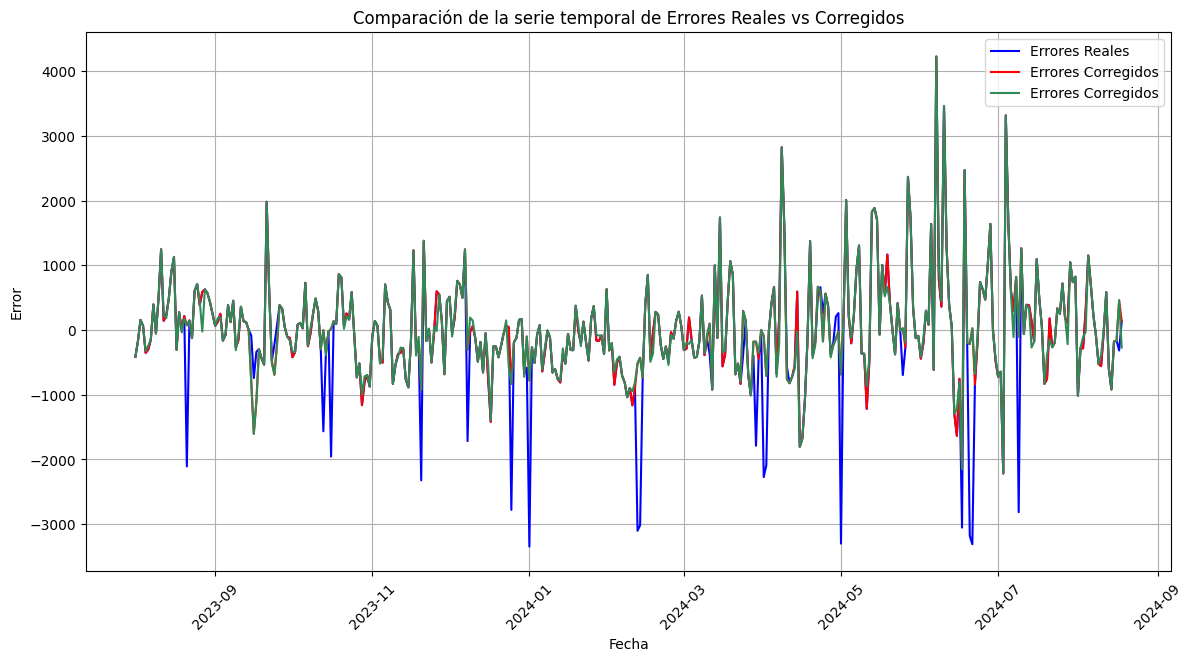

In [560]:
# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(df_comparation['date'], df_comparation['error'], label='Errores Reales', color='blue')
plt.plot(df_comparation['date'], df_comparation['error_corregido'], label='Errores Corregidos', color='red')
plt.plot(df_comparation['date'], df_comparation['error_finde_corregido'], label='Errores Corregidos', color='seagreen')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Errores Reales vs Corregidos')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [539]:
print(df_comparation['error_finde_corregido'].describe())

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 384.0       │
│ null_count ┆ 0.0         │
│ mean       ┆ 27.313832   │
│ std        ┆ 743.961221  │
│ min        ┆ -2218.672   │
│ 25%        ┆ -387.053017 │
│ 50%        ┆ -79.857     │
│ 75%        ┆ 342.6238    │
│ max        ┆ 4226.332    │
└────────────┴─────────────┘


# Días no laborables de corrido

In [540]:
# Cargar el dataset con la variacion de cada feriado
df_dias_laborables = pl.read_csv("cantidad_dias_no_laborables.csv")
df_dias_laborables = df_dias_laborables.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"))
print(df_dias_laborables)

shape: (1_825, 7)
┌────────────┬───────────────┬────────────┬───────────────┬─────────┬──────────────┬───────────────┐
│ date       ┆ cantidad_entr ┆ is_holiday ┆ holiday_name  ┆ weekday ┆ tipo_feriado ┆ cantidad_dias │
│ ---        ┆ egas          ┆ ---        ┆ ---           ┆ ---     ┆ ---          ┆ _no_laborable │
│ date       ┆ ---           ┆ bool       ┆ str           ┆ i64     ┆ i64          ┆ s             │
│            ┆ i64           ┆            ┆               ┆         ┆              ┆ ---           │
│            ┆               ┆            ┆               ┆         ┆              ┆ i64           │
╞════════════╪═══════════════╪════════════╪═══════════════╪═════════╪══════════════╪═══════════════╡
│ 2019-09-05 ┆ 2769          ┆ false      ┆ null          ┆ 4       ┆ 0            ┆ 0             │
│ 2019-09-06 ┆ 8474          ┆ false      ┆ null          ┆ 5       ┆ 0            ┆ 0             │
│ 2019-09-07 ┆ 613           ┆ false      ┆ null          ┆ 6       ┆ -1 

In [541]:
print(len(df_dias_laborables['date'].unique()) == len(df_dias_laborables))

False


#### Tratamos repetidos

In [542]:
print(df)

shape: (1_712, 7)
┌────────────┬──────┬───────────┬────────────┬────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_name   ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ ---            ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ str            ┆ i64          ┆ f64                │
╞════════════╪══════╪═══════════╪════════════╪════════════════╪══════════════╪════════════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 ┆ -1614.2124 ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  ┆ 667.872    ┆ null           ┆ 0            ┆ 1.0

In [543]:
#### Hacemos join con el df que teníamos donde ya tratamos los feriados
# Primero eliminamos fechas duplicadas en df_dias_laborables, ya que el valor en columna 'cantidad_dias_no_laborables' es el mismo
df_dias_laborables_unique = df_dias_laborables.unique(subset=["date"], keep="first")
df_w_dias_laborables = df.join(df_dias_laborables_unique[['date', 'cantidad_dias_no_laborables']], on="date", how="left")
print(df_w_dias_laborables)
print(len(df_w_dias_laborables['date'].unique()) == len(df_w_dias_laborables))

shape: (1_712, 8)
┌────────────┬──────┬───────────┬────────────┬─────────────┬─────────────┬────────────┬────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_nam ┆ tipo_feriad ┆ promedio_v ┆ cantidad_d │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ e           ┆ o           ┆ ariacion   ┆ ias_no_lab │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ ---         ┆ ---         ┆ ---        ┆ orables    │
│            ┆      ┆           ┆            ┆ str         ┆ i64         ┆ f64        ┆ ---        │
│            ┆      ┆           ┆            ┆             ┆             ┆            ┆ i64        │
╞════════════╪══════╪═══════════╪════════════╪═════════════╪═════════════╪════════════╪════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ null        ┆ 0           ┆ 1.0        ┆ 0          │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ null        ┆ 0           ┆ 1.0        ┆ 0          │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ null        ┆ -1          

## Predicción de errores

In [544]:
# Separar el último año para test
train_end_date = date(2023,7,31) #se entrena con 2 años y testea con el 5% o un mes pero aca vemos solo feriados así que está bien
# Separar el conjunto de entrenamiento y prueba basándote en la fecha
X_train = df_w_dias_laborables.filter(pl.col('date') <= train_end_date).select(['pred', 'tipo_feriado', 'promedio_variacion', 'cantidad_dias_no_laborables']).to_numpy()
X_test = df_w_dias_laborables.filter(pl.col('date') > train_end_date).select(['pred', 'tipo_feriado', 'promedio_variacion', 'cantidad_dias_no_laborables']).to_numpy()

y_train = df_w_dias_laborables.filter(pl.col('date') <= train_end_date).select('error').to_numpy()
y_test = df_w_dias_laborables.filter(pl.col('date') > train_end_date).select('error').to_numpy()
print(len(y_test))
print(df_w_dias_laborables.filter(pl.col('date') > train_end_date))

384
shape: (384, 8)
┌────────────┬──────┬───────────┬───────────┬─────────────┬─────────────┬─────────────┬────────────┐
│ date       ┆ true ┆ pred      ┆ error     ┆ holiday_nam ┆ tipo_feriad ┆ promedio_va ┆ cantidad_d │
│ ---        ┆ ---  ┆ ---       ┆ ---       ┆ e           ┆ o           ┆ riacion     ┆ ias_no_lab │
│ date       ┆ i64  ┆ f64       ┆ f64       ┆ ---         ┆ ---         ┆ ---         ┆ orables    │
│            ┆      ┆           ┆           ┆ str         ┆ i64         ┆ f64         ┆ ---        │
│            ┆      ┆           ┆           ┆             ┆             ┆             ┆ i64        │
╞════════════╪══════╪═══════════╪═══════════╪═════════════╪═════════════╪═════════════╪════════════╡
│ 2023-08-01 ┆ 3886 ┆ 4303.8433 ┆ -417.8433 ┆ null        ┆ 0           ┆ 1.0         ┆ 0          │
│ 2023-08-02 ┆ 4113 ┆ 4288.6836 ┆ -175.6836 ┆ null        ┆ 0           ┆ 1.0         ┆ 0          │
│ 2023-08-03 ┆ 4129 ┆ 3974.3462 ┆ 154.6538  ┆ null        ┆ 0          

In [548]:
# Parámetros a explorar
param_w_laborables = {
    'num_leaves': np.arange(20, 150, 10),  # número de hojas en cada árbol
    'learning_rate': np.linspace(0.01, 0.1, 10),  # tasa de aprendizaje
    'n_estimators': np.arange(100, 1000, 100),  # número de árboles
    'max_depth': np.arange(3, 15, 1),  # profundidad máxima del árbol
   # 'min_child_samples': np.arange(5, 100, 5),  # número mínimo de muestras en un nodo hoja
   # 'subsample': np.linspace(0.5, 1.0, 10),  # fracción de datos utilizada para construir cada árbol
   # 'colsample_bytree': np.linspace(0.5, 1.0, 10)  # fracción de columnas usada para construir cada árbol
}

# Inicializar el modelo
model_w_laborables = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', verbose=-1)

# Configurar la búsqueda aleatoria
random_search_w_laborables = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgbm,
    n_iter=10,  # Número de iteraciones de búsqueda
    scoring='neg_root_mean_squared_error',
    cv=tscv,  # Uso de TimeSeriesSplit en lugar de cv estándar
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [550]:
# Ajustar el modelo a los datos
random_search_w_laborables.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(objective='regression', verbose=-1),
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [551]:
# Obtener los mejores parámetros
best_params_w_laborables = random_search_w_laborables.best_params_
print(f"Mejores parámetros encontrados: {best_params}")

Mejores parámetros encontrados: {'subsample': 0.6111111111111112, 'reg_lambda': 0.7742636826811278, 'reg_alpha': 0.004641588833612782, 'n_estimators': 100, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.05555555555555555, 'colsample_bytree': 0.9444444444444444}


In [552]:
# Hacer predicciones
y_pred_w_laborables = random_search_w_laborables.predict(X_test)

In [553]:
len(dates_test) ##chequear porque el df con feriados no laborables es mas grande por 4 dias

384

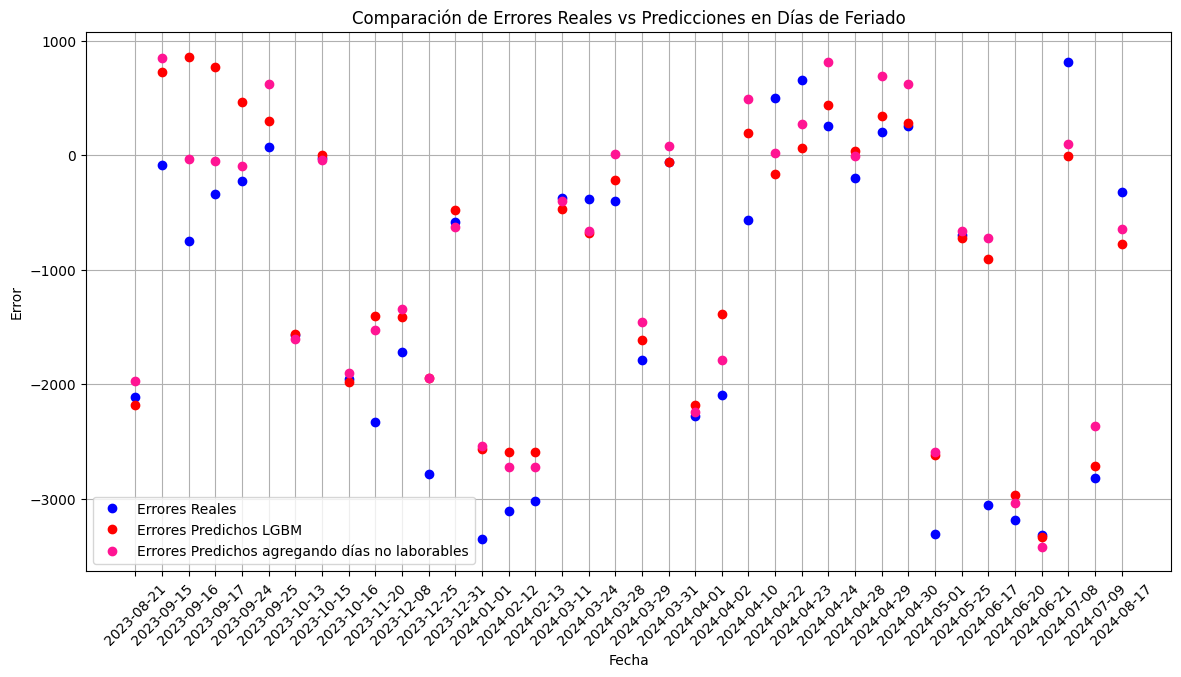

In [561]:
df_grafico2 = df_w_dias_laborables.filter(pl.col('date') > train_end_date).select(['date', 'tipo_feriado'])
dates_test = df_w_dias_laborables.filter(pl.col('date') > train_end_date).select('date').to_numpy().ravel()
# Crear un DataFrame con y_test y y_pred junto con las fechas
df_results_laborables = pl.DataFrame({
    'date': dates_test,
    'y_test': y_test.ravel(),
#    'y_pred_lgbm': y_pred_lgbm,
    'y_pred_with_no_laborables': y_pred_w_laborables
})

# Hacer un join para obtener solo los días de feriado (tipo_feriado == 1 o 2)
df_feriado_results_laborables = df_results_laborables.join(
    df_grafico2.filter((pl.col('tipo_feriado') == 1) | (pl.col('tipo_feriado') == 2)), 
    on='date', 
    how='inner'
)

# Crear un índice para cada fecha
df_feriado_results_laborables = df_feriado_results_laborables.with_columns([
    pl.arange(0, df_feriado_results_laborables.height).alias('index')
])

plt.figure(figsize=(14, 7))

# Graficar los valores de y_test y las predicciones usando el índice en el eje X
plt.plot(df_feriado_results_laborables['index'], df_feriado_results_laborables['y_test'], label='Errores Reales', color='blue', marker='o', linestyle='None')
plt.plot(df_feriado_results['index'], df_feriado_results['y_pred_lgbm'], label='Errores Predichos LGBM', color='red', marker='o', linestyle='None')
plt.plot(df_feriado_results_laborables['index'], df_feriado_results_laborables['y_pred_with_no_laborables'], label='Errores Predichos agregando días no laborables', color='deeppink', marker='o', linestyle='None')

# Reemplazar las etiquetas del eje X por las fechas correspondientes
plt.xticks(df_feriado_results['index'], df_feriado_results['date'], rotation=45)

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de Errores Reales vs Predicciones en Días de Feriado')
plt.legend()
plt.grid(True)
plt.show()


#### Veamos si mejoró

In [554]:
### Lo anterior fue para el gráfico, pero para análisis tengamos en cuenta los fin de semana también
df_feriado_results_laborables = df_results_laborables.join(
    df_grafico2.filter(pl.col('tipo_feriado') != 0), 
    on='date', 
    how='inner'
)

In [555]:
print(df_feriado_results_laborables)

shape: (138, 4)
┌────────────┬───────────┬───────────────────────────┬──────────────┐
│ date       ┆ y_test    ┆ y_pred_with_no_laborables ┆ tipo_feriado │
│ ---        ┆ ---       ┆ ---                       ┆ ---          │
│ date       ┆ f64       ┆ f64                       ┆ i64          │
╞════════════╪═══════════╪═══════════════════════════╪══════════════╡
│ 2023-08-05 ┆ -355.2804 ┆ -40.322014                ┆ -1           │
│ 2023-08-06 ┆ -304.7046 ┆ -40.986023                ┆ -1           │
│ 2023-08-12 ┆ 140.4397  ┆ -53.558685                ┆ -1           │
│ 2023-08-13 ┆ 224.5967  ┆ 62.78659                  ┆ -1           │
│ 2023-08-19 ┆ 3.7073    ┆ 51.065629                 ┆ -1           │
│ …          ┆ …         ┆ …                         ┆ …            │
│ 2024-08-04 ┆ 294.13867 ┆ 317.581288                ┆ -1           │
│ 2024-08-10 ┆ -559.8755 ┆ -186.32699                ┆ -1           │
│ 2024-08-11 ┆ -39.1438  ┆ -29.603588                ┆ -1           │
│ 20

In [556]:
df_comparation = df_comparation.join(df_feriado_results_laborables[['date', 'y_pred_with_no_laborables']], on='date', how='left')
df_comparation = df_comparation.with_columns(
    (pl.col("pred") + pl.col("y_pred_with_no_laborables")).alias("pred_laborables_semi_corregido")
)
df_comparation = df_comparation.with_columns(
                pl.when(pl.col('pred_laborables_semi_corregido').is_null()).then(pl.col('pred')).otherwise(pl.col('pred_laborables_semi_corregido')).alias('pred_laborable_corregido')
            )
df_comparation = df_comparation.with_columns(
    (pl.col("true") - pl.col("pred_laborable_corregido")).alias("error_laborables_corregido")
)
print(df_comparation)

shape: (384, 19)
┌────────────┬──────┬───────────┬───────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ date       ┆ true ┆ pred      ┆ error     ┆ … ┆ y_pred_wit ┆ pred_labor ┆ pred_labor ┆ error_lab │
│ ---        ┆ ---  ┆ ---       ┆ ---       ┆   ┆ h_no_labor ┆ ables_semi ┆ able_corre ┆ orables_c │
│ date       ┆ i64  ┆ f64       ┆ f64       ┆   ┆ ables      ┆ _corregido ┆ gido       ┆ orregido  │
│            ┆      ┆           ┆           ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│            ┆      ┆           ┆           ┆   ┆ f64        ┆ f64        ┆ f64        ┆ f64       │
╞════════════╪══════╪═══════════╪═══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 2023-08-01 ┆ 3886 ┆ 4303.8433 ┆ -417.8433 ┆ … ┆ null       ┆ null       ┆ 4303.8433  ┆ -417.8433 │
│ 2023-08-02 ┆ 4113 ┆ 4288.6836 ┆ -175.6836 ┆ … ┆ null       ┆ null       ┆ 4288.6836  ┆ -175.6836 │
│ 2023-08-03 ┆ 4129 ┆ 3974.3462 ┆ 154.6538  ┆ … ┆ null       ┆ null       

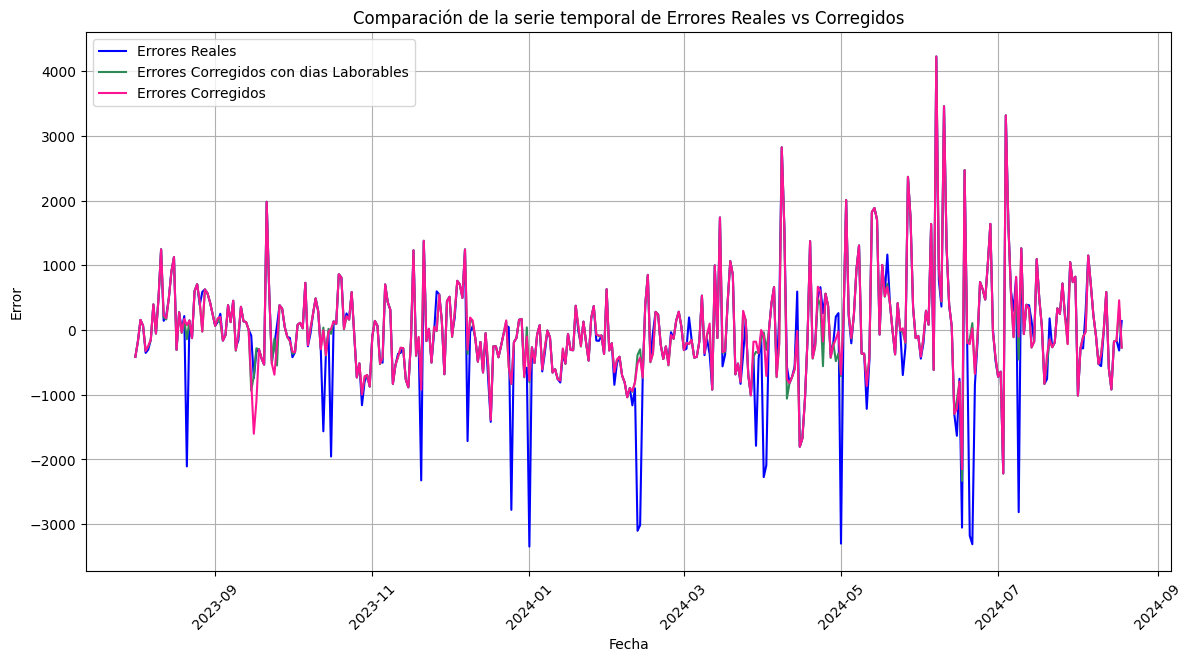

In [562]:
# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(df_comparation['date'], df_comparation['error'], label='Errores Reales', color='blue')
plt.plot(df_comparation['date'], df_comparation['error_laborables_corregido'], label='Errores Corregidos con dias Laborables', color='seagreen')
plt.plot(df_comparation['date'], df_comparation['error_finde_corregido'], label='Errores Corregidos', color='deeppink')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Errores Reales vs Corregidos')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [558]:
print(df_comparation['error_finde_corregido'].describe())

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 384.0       │
│ null_count ┆ 0.0         │
│ mean       ┆ 27.313832   │
│ std        ┆ 743.961221  │
│ min        ┆ -2218.672   │
│ 25%        ┆ -387.053017 │
│ 50%        ┆ -79.857     │
│ 75%        ┆ 342.6238    │
│ max        ┆ 4226.332    │
└────────────┴─────────────┘


In [559]:
print(df_comparation['error_laborables_corregido'].describe())

shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 384.0        │
│ null_count ┆ 0.0          │
│ mean       ┆ 24.592915    │
│ std        ┆ 739.7647     │
│ min        ┆ -2334.928161 │
│ 25%        ┆ -397.808629  │
│ 50%        ┆ -89.838      │
│ 75%        ┆ 332.708      │
│ max        ┆ 4226.332     │
└────────────┴──────────────┘


Parece haber mejorado apenas con la cantidad de días no laborables de corrido.

# Features ventas

In [563]:
print(df)

shape: (1_712, 7)
┌────────────┬──────┬───────────┬────────────┬────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_name   ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ ---            ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ str            ┆ i64          ┆ f64                │
╞════════════╪══════╪═══════════╪════════════╪════════════════╪══════════════╪════════════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 ┆ -1614.2124 ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  ┆ 667.872    ┆ null           ┆ 0            ┆ 1.0

In [566]:
# Cargar el dataset con la variacion de cada feriado
df_ventas = pl.read_csv("cantidad_ventas.csv")
df_ventas = df_ventas.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"))
print(df_ventas)

shape: (1_779, 3)
┌────────────┬───────────────────┬─────────────────┐
│ date       ┆ cantidad_entregas ┆ cantidad_ventas │
│ ---        ┆ ---               ┆ ---             │
│ date       ┆ i64               ┆ i64             │
╞════════════╪═══════════════════╪═════════════════╡
│ 2019-09-05 ┆ 2769              ┆ 183341          │
│ 2019-09-06 ┆ 8474              ┆ 207252          │
│ 2019-09-07 ┆ 613               ┆ 189266          │
│ 2019-09-08 ┆ 346               ┆ 166045          │
│ 2019-09-09 ┆ 4814              ┆ 204670          │
│ …          ┆ …                 ┆ …               │
│ 2024-07-14 ┆ 539               ┆ 132314          │
│ 2024-07-15 ┆ 4880              ┆ 216373          │
│ 2024-07-16 ┆ 6048              ┆ 198518          │
│ 2024-07-17 ┆ 5371              ┆ 201872          │
│ 2024-07-18 ┆ 3562              ┆ 215586          │
└────────────┴───────────────────┴─────────────────┘


In [569]:
df_ventas = df_w_dias_laborables.join(df_ventas[['date', 'cantidad_ventas']], on="date", how="left")
df_ventas = df_ventas.filter(pl.col('date') <= date(2024,7,18))
print(df_ventas)

shape: (1_681, 9)
┌────────────┬──────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ … ┆ tipo_feria ┆ promedio_v ┆ cantidad_ ┆ cantidad_ │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆   ┆ do         ┆ ariacion   ┆ dias_no_l ┆ ventas    │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆   ┆ ---        ┆ ---        ┆ aborables ┆ ---       │
│            ┆      ┆           ┆            ┆   ┆ i64        ┆ f64        ┆ ---       ┆ i64       │
│            ┆      ┆           ┆            ┆   ┆            ┆            ┆ i64       ┆           │
╞════════════╪══════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ … ┆ 0          ┆ 1.0        ┆ 0         ┆ 245256    │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ … ┆ 0          ┆ 1.0        ┆ 0         ┆ 235333    │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ … ┆ -1         ┆ 1.0      

## Predicción de errores

In [572]:
# Separar el último año para test
train_end_date = date(2023,7,31) #se entrena con 2 años y testea con el 5% o un mes pero aca vemos solo feriados así que está bien
# Separar el conjunto de entrenamiento y prueba basándote en la fecha
X_train = df_ventas.filter(pl.col('date') <= train_end_date).select(['pred', 'tipo_feriado', 'promedio_variacion', 'cantidad_ventas']).to_numpy()
X_test = df_ventas.filter(pl.col('date') > train_end_date).select(['pred', 'tipo_feriado', 'promedio_variacion', 'cantidad_ventas']).to_numpy()

y_train = df_ventas.filter(pl.col('date') <= train_end_date).select('error').to_numpy()
y_test = df_ventas.filter(pl.col('date') > train_end_date).select('error').to_numpy()

In [573]:
# Ajustar el modelo a los datos
random_search_w_laborables.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(objective='regression', verbose=-1),
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [ ]:
# Obtener los mejores parámetros
best_params_w_laborables = random_search_w_laborables.best_params_
print(f"Mejores parámetros encontrados: {best_params}")

In [574]:
# Obtener los mejores parámetros
best_params_ventas = random_search_w_laborables.best_params_
print(f"Mejores parámetros encontrados: {best_params_ventas}")

Mejores parámetros encontrados: {'num_leaves': 30, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05000000000000001}


In [575]:
# Hacer predicciones
y_pred_ventas = random_search_w_laborables.predict(X_test)

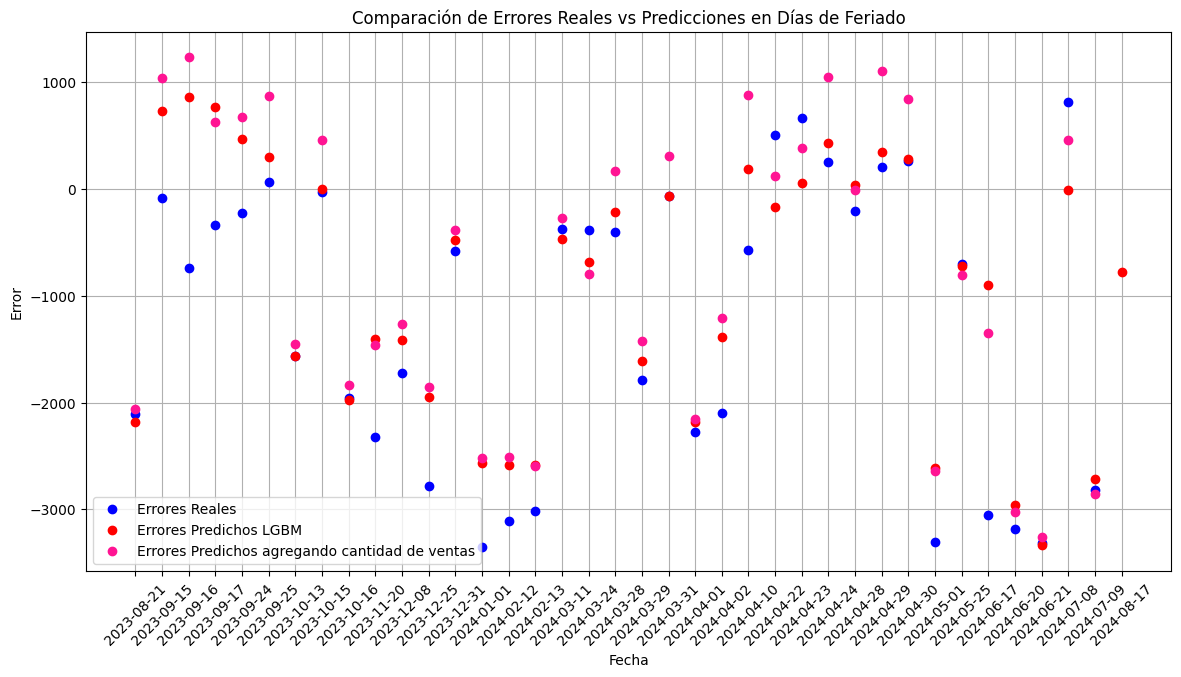

In [576]:
df_grafico3 = df_ventas.filter(pl.col('date') > train_end_date).select(['date', 'tipo_feriado'])
dates_test = df_ventas.filter(pl.col('date') > train_end_date).select('date').to_numpy().ravel()
# Crear un DataFrame con y_test y y_pred junto con las fechas
df_results_ventas = pl.DataFrame({
    'date': dates_test,
    'y_test': y_test.ravel(),
    'y_pred_ventas': y_pred_ventas
})

# Hacer un join para obtener solo los días de feriado (tipo_feriado == 1 o 2)
df_feriado_results_ventas = df_results_ventas.join(
    df_grafico2.filter((pl.col('tipo_feriado') == 1) | (pl.col('tipo_feriado') == 2)), 
    on='date', 
    how='inner'
)

# Crear un índice para cada fecha
df_feriado_results_ventas = df_feriado_results_ventas.with_columns([
    pl.arange(0, df_feriado_results_ventas.height).alias('index')
])

plt.figure(figsize=(14, 7))

# Graficar los valores de y_test y las predicciones usando el índice en el eje X
plt.plot(df_feriado_results_ventas['index'], df_feriado_results_ventas['y_test'], label='Errores Reales', color='blue', marker='o', linestyle='None')
plt.plot(df_feriado_results['index'], df_feriado_results['y_pred_lgbm'], label='Errores Predichos LGBM', color='red', marker='o', linestyle='None')
plt.plot(df_feriado_results_ventas['index'], df_feriado_results_ventas['y_pred_ventas'], label='Errores Predichos agregando cantidad de ventas', color='deeppink', marker='o', linestyle='None')

# Reemplazar las etiquetas del eje X por las fechas correspondientes
plt.xticks(df_feriado_results['index'], df_feriado_results['date'], rotation=45)

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de Errores Reales vs Predicciones en Días de Feriado')
plt.legend()
plt.grid(True)
plt.show()
